In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pysentani import *
import sentani as sti
survey = find_survey("../data-anonymous")

../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx


In [6]:
survey['access_type'] = survey['village_name'].apply(lambda x: sti.access_map.get(x))

In [40]:
frequency = {'genset_expenditure':'daily'}

multiplier = {'daily':30}

# create new columns with same monthly frequency
for column in frequency.keys():
    # adjust expenditure frequency
    expenditure = survey[column] * multiplier[frequency[column]]
    new_column = column + '_monthly'
    survey[new_column] = expenditure



pd.set_option('max_rows', 200)
survey.groupby(['access_type'])[['genset_expenditure_monthly']].agg(['sum','count'])

genset_expenditure_monthly      
                                           sum count
access_type                                         
PLN_grid                              17850000     3
PLN_microgrid                         63600000    57
community_microgrid                    4500000     1
no_access                            202170120   178

In [41]:
#monthly expenditure divided by 960 rp per kWh (.08 USD per kWh * 12000 rp to USD exchange)
def genset_kwh_conversion(df):
    converted = (df['genset_expenditure_monthly']/(960))
    return converted

survey['genset_kWh'] = survey.apply(genset_kwh_conversion, axis=1)

# kWh multiplied by Lawrence Berkely Labratory estimation of 1100 g CO2 per kWh
def CO2_emission(df1):
    converted = df1['genset_kWh']*1100 
    return converted

survey['CO2_g'] = survey.apply(CO2_emission, axis=1)

# Potential Photovoltaic carbon emissions (g CO2 per kWh), (if genset replaced by PV)
def PV_emission(df2):
    converted = df2['genset_kWh']*100
    return converted
survey['PV_emission'] = survey.apply(PV_emission, axis=1)

# CO2 reduction (co2(g) column - PV_emission column)

def CO2_reduction(df3):
    converted = df3['CO2_g']-survey['PV_emission']
    return converted
survey['CO2_reduction'] = survey.apply(CO2_reduction, axis=1)

In [42]:
df = survey.groupby(['access_type',
                     'village_name'])[['genset_expenditure_monthly',
                                  'genset_kWh','CO2_g','PV_emission','CO2_reduction']].agg(['sum']).dropna()


In [43]:
df

genset_expenditure_monthly genset_kWh  \
                                                        sum        sum   
access_type         village_name                                         
PLN_grid            Hobong                         15000000  15625.000   
                    Khamayakha                      2850000   2968.750   
PLN_microgrid       Ayapo                          63600000  66250.000   
community_microgrid Atamali                         4500000   4687.500   
no_access           Abar                           20400000  21250.000   
                    Ebunfauw                       26700000  27812.500   
                    Kalio                          13800000  14375.000   
                    Kampung_Baru                   34560000  36000.000   
                    Khageuw                         8400000   8750.000   
                    Puai                           59610000  62093.750   
                    Yoboi                          20400120  21250.125   
                    Yokiwa                         18300000  19062.500   

                                       CO2_g PV_emission CO2_reduction  
                                         sum         sum           sum  
access_type         village_name                                        
PLN_grid            Hobong        17187500.0   1562500.0    17031250.0  
                    Khamayakha     3265625.0    296875.0     2953125.0  
PLN_microgrid       Ayapo         72875000.0   6625000.0    63968750.0  
community_microgrid Atamali        5156250.0    468750.0     5000000.0  
no_access           Abar          23375000.0   2125000.0    20718750.0  
                    Ebunfauw      30593750.0   2781250.0    26375000.0  
                    Kalio         15812500.0   1437500.0    13937500.0  
                    Kampung_Baru  39600000.0   3600000.0    35381250.0  
                    Khageuw        9625000.0    875000.0     8375000.0  
                    Puai          68303125.0   6209375.0    61740625.0  
                    Yoboi         23375137.5   2125012.5    18843887.5  
                    Yokiwa        20968750.0   1906250.0    18468750.0

In [45]:
df.reset_index(inplace=True)

In [55]:
df.head()

,access_type,vn,gen_sum,genset_kwh,CO2_emission,PV,CO2_reduction
0,PLN_grid,Hobong,15000000,15625.00,17187500,1562500,17031250
1,PLN_grid,Khamayakha,2850000,2968.75,3265625,296875,2953125
2,PLN_microgrid,Ayapo,63600000,66250.00,72875000,6625000,63968750
3,community_microgrid,Atamali,4500000,4687.50,5156250,468750,5000000
4,no_access,Abar,20400000,21250.00,23375000,2125000,20718750


In [17]:
df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [48]:
df.columns = ['access_type', 'vn', 'gen_sum', 'genset_kwh', 'CO2_emission','PV','CO2_reduction']

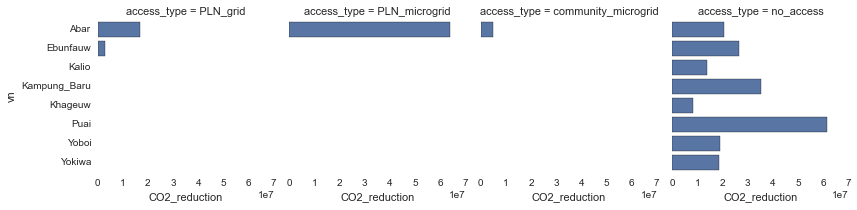

In [54]:
g = sns.FacetGrid(col="access_type", data=df)
g = (g.map(sns.barplot, "CO2_reduction", "vn")
    .set())